In [1]:
import base64
import collections
import copy
import datetime
import itertools
import json
import math
import os
import operator
import pickle
import random
import re
import shutil
import sys
import time

import cv2
import Image
import keras
from keras import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL as pil
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm
import tensorflow as tf

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
mpl.rcParams['figure.figsize'] = 20, 12
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

linewidth = 1.0
dotsize = 15

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/lo

In [2]:
base_dir = '/media/ntfs/data/invasive_species/'
input_dir = os.path.join(base_dir, 'input')
tmp_dir = os.path.join(base_dir, 'tmp')
output_dir = os.path.join(base_dir, 'output')

In [3]:
train_dir = os.path.join(tmp_dir, 'train')
val_dir = os.path.join(tmp_dir, 'val')
test_dir = os.path.join(tmp_dir, 'test')

In [4]:
train_pos_dir = os.path.join(train_dir, 'pos')
train_neg_dir = os.path.join(train_dir, 'neg')
val_pos_dir = os.path.join(val_dir, 'pos')
val_neg_dir = os.path.join(val_dir, 'neg')

In [5]:
img_size = (433, 577)

In [6]:
conv_base = keras.applications.VGG16(
                weights='imagenet',
                include_top=False,
                input_shape=(img_size[0], img_size[1], 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 433, 577, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 433, 577, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 433, 577, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 216, 288, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 216, 288, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 216, 288, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 108, 144, 128)     0         
__________

In [7]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 13, 18, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 119808)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               30671104  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 45,386,049
Trainable params: 37,750,785
Non-trainable params: 7,635,264
_________________________________________________________________


In [9]:
model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=img_size,
                    batch_size=16,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                            val_dir,
                            target_size=img_size,
                            batch_size=16,
                            class_mode='binary')

history = model.fit_generator(
            train_generator,
            steps_per_epoch=110,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=28)

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Epoch 1/30
110/110 [==============================] - 111s - loss: 0.3781 - acc: 0.8795 - val_loss: 0.2067 - val_acc: 0.9397
Epoch 2/30
110/110 [==============================] - 105s - loss: 0.2167 - acc: 0.9244 - val_loss: 0.2067 - val_acc: 0.9413
Epoch 3/30
110/110 [==============================] - 102s - loss: 0.1654 - acc: 0.9534 - val_loss: 0.0757 - val_acc: 0.9729
Epoch 4/30
110/110 [==============================] - 104s - loss: 0.1379 - acc: 0.9591 - val_loss: 0.1296 - val_acc: 0.9616
Epoch 5/30
110/110 [==============================] - 107s - loss: 0.1483 - acc: 0.9572 - val_loss: 0.1130 - val_acc: 0.9707
Epoch 6/30
110/110 [==============================] - 107s - loss: 0.1731 - acc: 0.9549 - val_loss: 0.1611 - val_acc: 0.9594
Epoch 7/30
110/110 [==============================] - 107s - loss: 0.1062 - acc: 0.9699 - val_loss: 0.1546 - val_acc: 0.9774
Epoch 8/30
110/110 [======================

In [11]:
model.save('vgg16_01.h5')

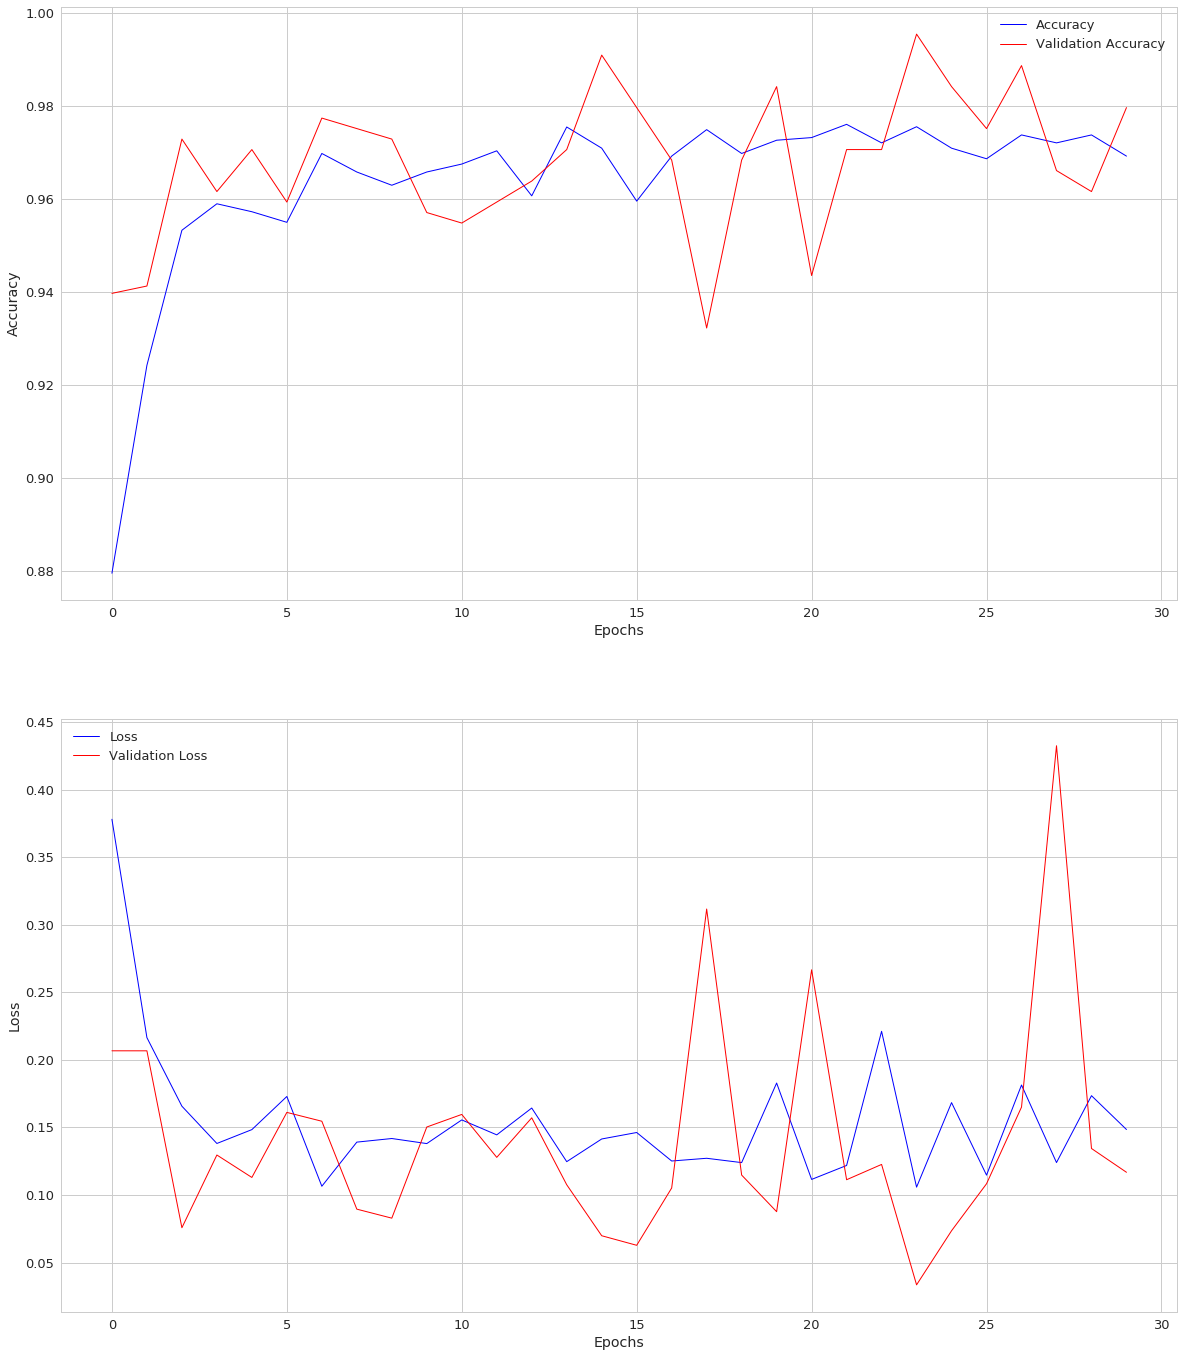

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(20, 24))

plt.subplot(2, 1, 1)

_ = plt.plot(epochs, acc, 'b', label='Accuracy', linewidth=linewidth)
_ = plt.plot(epochs, val_acc, 'r', label='Validation Accuracy', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Accuracy')

_ = plt.legend()

plt.subplot(2, 1, 2)

_ = plt.plot(epochs, loss, 'b', label='Loss', linewidth=linewidth)
_ = plt.plot(epochs, val_loss, 'r', label='Validation Loss', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')

_ = plt.legend()